# PersonalityEstimatorModel

## Import Packages

In [3]:
from math import floor, ceil
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS

import lightgbm as lgb
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
sns.set_context("poster")
import gensim
import os
import collections
import pickle
import smart_open
import random
import re

## Import Data

In [2]:
df = pd.read_csv("../input/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
# confirm data types
df.groupby("type").count()

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


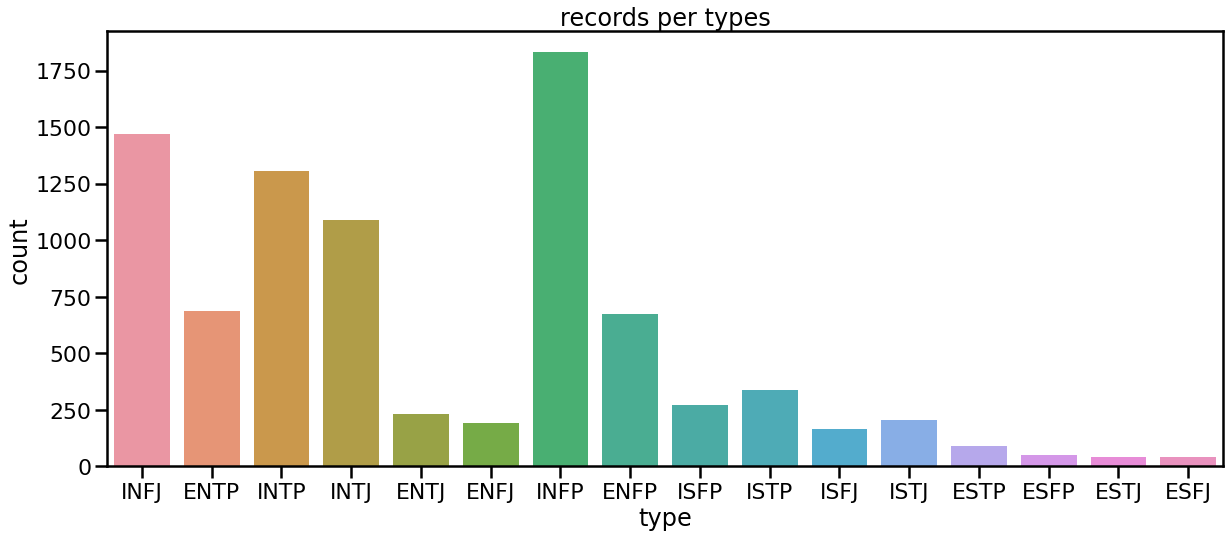

In [4]:
# visualize records per types
f, ax = plt.subplots(figsize = (20, 8))
ax = sns.countplot(df["type"])
plt.title("records per types")
plt.savefig("../output/records per types.png")

## Preprocessing

### Change line unit from users to posts

In [5]:
# def extract(posts, new_posts):
#     for post in posts[1].split("|||"):
#         new_posts.append((posts[0], post))

# posts = []
# df.apply(lambda x: extract(x, posts), axis=1)
# df = pd.DataFrame(posts, columns=["type", "posts"])

In [4]:
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


### Preprocess and subsampling using gensim

In [9]:
df["posts"].apply(lambda x: x[2])

0       t
1       '
2       o
3       e
4       o
       ..
8670    t
8671    o
8672    o
8673     
8674    t
Name: posts, Length: 8675, dtype: object

In [7]:
def preprocess_text(df, remove_special=True):

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Remove multiple letter repating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove Personality Types Words
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["posts"] = df["posts"].apply(lambda x: p.sub(' TokenType ',x))
    return df

# def subsample(df):
#     groups = df.groupby("type").count()
#     groups.sort_values("posts", ascending=False, inplace=True)
    
#     min_num = groups["posts"][-1]
#     min_ind = groups.index[-1]
#     ndf = df[df["type"] == min_ind]

#     for pt in groups.index[:-1]:
#         print(min_num,pt)
#         tdf = df[df["type"] == pt].sample(min_num)
#         ndf = pd.concat([ndf, tdf])
#     return ndf

def read_corpus(df):
    # preprocess
#     df = subsample(preprocess_text(df))
    df = preprocess_text(df)
    
    for index, row in df.iterrows():
        yield gensim.models.doc2vec.TaggedDocument(words=gensim.utils.simple_preprocess(row['posts']), tags=row['type'])

df = list(read_corpus(df))

In [8]:
df[0]

TaggedDocument(words=['tokentype', 'and', 'tokentype', 'moments', 'sportscenter', 'not', 'top', 'ten', 'plays', 'pranks', 'what', 'has', 'been', 'the', 'most', 'lifechanging', 'experience', 'in', 'your', 'life', 'on', 'repeat', 'for', 'most', 'of', 'today', 'may', 'the', 'perc', 'experience', 'immerse', 'you', 'the', 'last', 'thing', 'my', 'infj', 'friend', 'posted', 'on', 'his', 'facebook', 'before', 'committing', 'suicide', 'the', 'next', 'day', 'rest', 'in', 'peace', 'hello', 'enfj', 'sorry', 'to', 'hear', 'of', 'your', 'distress', 'its', 'only', 'natural', 'for', 'relationship', 'to', 'not', 'be', 'perfection', 'all', 'the', 'time', 'in', 'every', 'moment', 'of', 'existence', 'try', 'to', 'figure', 'the', 'hard', 'times', 'as', 'times', 'of', 'growth', 'as', 'welcome', 'and', 'stuff', 'game', 'set', 'match', 'prozac', 'wellbrutin', 'at', 'least', 'thirty', 'minutes', 'of', 'moving', 'your', 'legs', 'and', 'dont', 'mean', 'moving', 'them', 'while', 'sitting', 'in', 'your', 'same', '

## Visualization

### Create Dataframe for visualization

In [9]:
post, type = zip(*[(doc.words, doc.tags) for doc in df])
post = [' '.join(post[i]) for i in range(len(post))]
df4visual = pd.DataFrame({"type" : type, "post": post})

df4visual["nw"] = df4visual["post"].apply(lambda x: len(re.findall(r'\w+', x))) # number of words
df4visual["Len"] = df4visual["post"].apply(len) # length

In [10]:
df4visual

,type,post,nw,Len
0,INFJ,tokentype and tokentype moments sportscenter n...,541,3063
1,ENTP,im finding the lack of me in these posts very ...,1095,5775
2,INTP,good one of course to which say know thats my ...,339,1872
3,INTJ,dear intp enjoyed our conversation the other d...,1025,5567
4,ENTJ,youre fired thats another silly misconception ...,507,2774
...,...,...,...,...
8670,ISFP,ixfp just because always think of cats as fi d...,775,4255
8671,ENFP,soif this thread already exists someplace else...,553,2979
8672,INTP,so many questions when do these things would t...,913,5082
8673,INFP,am very conflicted right now when it comes to ...,1573,8501


### jointplot: number of words & length

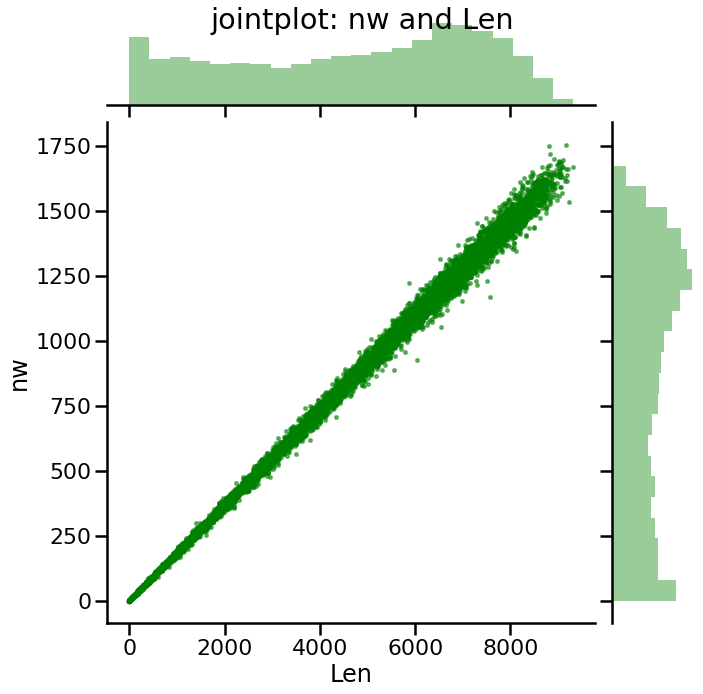

In [11]:
ax = sns.jointplot("Len", "nw", data=df4visual, height=10, kind="scatter", s=10, color="g", alpha=0.5)
plt.suptitle("jointplot: nw and Len")
plt.savefig("../output/jointplot nw and Len.png")

### boxplot and violinplot: counts of nw and length per type

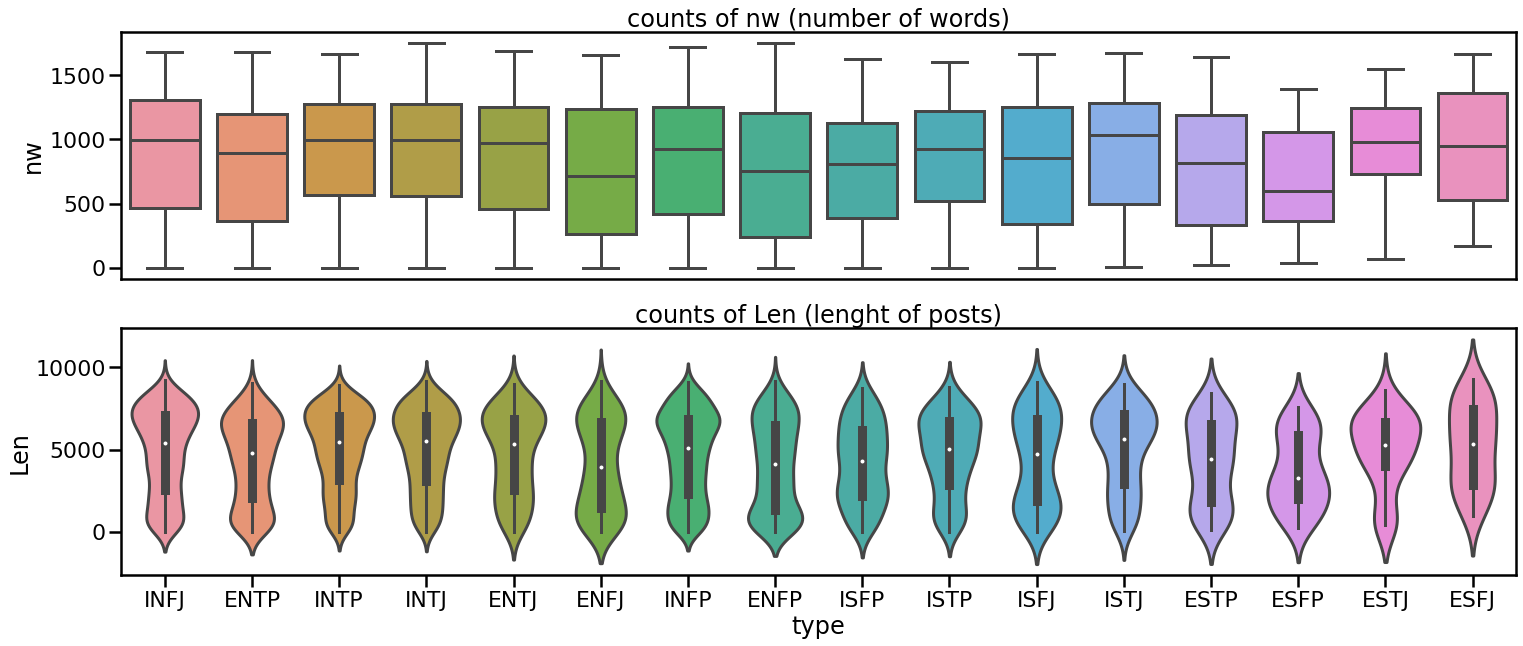

In [35]:
f, ax = plt.subplots(2, 1, figsize = (25, 10))
sns.boxplot("type", "nw", data=df4visual, ax=ax[0])
ax[0].set_title("counts of nw (number of words)")

sns.violinplot("type", "Len", data=df4visual, ax=ax[1])
ax[1].set_title("counts of Len (lenght of posts)")

ax[0].set_xticks([])
ax[0].set_xlabel("");

plt.savefig("../output/count nw and Len.png")

### making wordcloud

## Feature Engineering

### Create train/test datasets

In [13]:
total_num_obs = len(df)
train_corpus = df[0:floor(3*total_num_obs/4)]
test_corpus = df[floor(3*total_num_obs/4):]

train_posts, train_ie, train_sn, train_tf, train_pj = zip(*[(doc.words, doc.tags[0], doc.tags[1], doc.tags[2],doc.tags[3]) for doc in train_corpus])
test_posts, test_ie, test_sn, test_tf, test_pj = zip(*[(doc.words, doc.tags[0], doc.tags[1], doc.tags[2], doc.tags[3]) for doc in test_corpus])

In [14]:
train_tags = [train_corpus[i].tags for i in range(len(train_corpus))]

In [15]:
import collections
c = collections.Counter(train_tags)
c

Counter({'INFJ': 1100,
         'ENTP': 530,
         'INTP': 960,
         'INTJ': 830,
         'ENTJ': 167,
         'ENFJ': 143,
         'INFP': 1386,
         'ENFP': 496,
         'ISFP': 198,
         'ISTP': 255,
         'ISFJ': 124,
         'ISTJ': 145,
         'ESTP': 71,
         'ESFP': 36,
         'ESTJ': 30,
         'ESFJ': 35})

### Vectorize posts by using doc2vec

In [16]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=55)
model.build_vocab(train_corpus) 
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter) 


/Users/shoki/.anyenv/envs/pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


CPU times: user 14min 21s, sys: 11.2 s, total: 14min 32s
Wall time: 5min 42s


In [17]:
#play
model.infer_vector(['I', 'feel', 'sad'])

array([ 0.10863358, -0.28136095, -0.57263714,  0.02721277,  0.33407462,
        0.19132774,  0.26936638, -0.20576894, -0.1311325 ,  0.29685408,
       -0.00125393, -0.49349815,  0.34586942, -0.08363786, -0.14803058,
       -0.04334811, -0.34974578, -0.19814408,  0.2924565 ,  0.17163314,
       -0.14840433,  0.07146426,  0.27095705, -0.00110244,  0.0869334 ,
        0.04448445, -0.15265454,  0.29466397,  0.00974288,  0.07296595,
       -0.02274489, -0.1096658 , -0.09756945, -0.02760719, -0.14461713,
       -0.07351087, -0.2464368 ,  0.26600516, -0.20432712, -0.12498533,
       -0.08686385,  0.14943369, -0.16545974,  0.15021199,  0.17032187,
       -0.24235262, -0.23460749,  0.04462278,  0.11608414, -0.18758276,
        0.05475632, -0.16799027,  0.0659088 ,  0.01308316, -0.09156124,
       -0.0672031 ,  0.10845871,  0.16255973, -0.12704906,  0.17452465,
       -0.03558537,  0.21736333, -0.04225487, -0.13337387,  0.16371062,
       -0.16287558,  0.20484379,  0.1022632 , -0.10270438,  0.06

### Create input data for modeling

In [18]:
# X_train
X = []
for i in range(len(train_posts)):
    X.append(model.infer_vector(train_posts[i]))
X_train = np.asarray(X)

with open("../output/X_train.pickle", "wb") as f:
    pickle.dump(X_train, f)

In [19]:
# y_train
y_train = []
y_train_ie = np.asarray([1 if i  ==  'I' else 0 for i in train_ie])
y_train_sn = np.asarray([1 if i  ==  'S' else 0 for i in train_sn])
y_train_tf = np.asarray([1 if i  ==  'T' else 0 for i in train_tf])
y_train_pj = np.asarray([1 if i  ==  'P' else 0 for i in train_pj])

y_train = [y_train_ie, y_train_sn, y_train_tf, y_train_pj]

with open("../output/y_train.pickle", "wb") as f:
    pickle.dump(y_train, f)

In [20]:
# X_test
X = []
for i in range(len(test_posts)):
    X.append(model.infer_vector(test_posts[i]))
X_test = np.asarray(X)

with open("../output/X_test.pickle", "wb") as f:
    pickle.dump(X_test, f)

In [21]:
y_test = []
y_test_ie = np.asarray([1 if i  ==  'I' else 0 for i in test_ie])
y_test_sn = np.asarray([1 if i  ==  'S' else 0 for i in test_sn])
y_test_tf = np.asarray([1 if i  ==  'T' else 0 for i in test_tf])
y_test_pj = np.asarray([1 if i  ==  'P' else 0 for i in test_pj])

y_test = [y_test_ie, y_test_sn, y_test_tf, y_test_pj]

with open("../output/y_test.pickle", "wb") as f:
    pickle.dump(y_test, f)

In [22]:
X_train

array([[-0.5978167 , -1.0745989 , -2.8484526 , ..., -0.1395104 ,
        -0.5890574 , -0.24295521],
       [-1.0052441 , -1.8734307 , -0.09858   , ..., -0.7839099 ,
        -1.7162434 ,  0.1682745 ],
       [ 0.40915954, -1.2125038 , -1.4982277 , ...,  0.11358638,
        -1.5533249 ,  1.0955884 ],
       ...,
       [ 1.824158  ,  0.47895822, -1.5074068 , ...,  1.1420652 ,
        -2.2935495 ,  1.2304496 ],
       [-0.05448646,  2.5658162 , -2.982684  , ...,  1.1277777 ,
        -0.05180861, -0.5015622 ],
       [ 1.7075006 ,  0.01860632, -4.6829805 , ...,  0.51864654,
         0.0458473 ,  2.1459873 ]], dtype=float32)

## Modeling

### Make models by using RandomForestClassifier / LogisticRegression

In [23]:
rfc_ie = RandomForestClassifier()
rfc_ie.fit(X_train, y_train[0])

rfc_sn = RandomForestClassifier()
rfc_sn.fit(X_train, y_train[1])

rfc_tf = RandomForestClassifier()
rfc_tf.fit(X_train, y_train[2])

rfc_pj = RandomForestClassifier()
rfc_pj.fit(X_train, y_train[3])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
logreg_ie = linear_model.LogisticRegression()
logreg_ie.fit(X_train, y_train[0])

logreg_sn = linear_model.LogisticRegression()
logreg_sn.fit(X_train, y_train[1])

logreg_tf = linear_model.LogisticRegression()
logreg_tf.fit(X_train, y_train[2])

logreg_pj = linear_model.LogisticRegression()
logreg_pj.fit(X_train, y_train[3])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Verify models by samples

In [25]:
X_sample = "I feel sad"
X_sample = gensim.utils.simple_preprocess(X_sample)
X_sample = model.infer_vector(X_sample)
X_sample = np.array(X_sample).reshape(1, 100).tolist()

In [26]:
y_sample = logreg_tf.predict_proba(X_sample)
y_sample

array([[0.624011, 0.375989]])

### Test models

In [27]:
y_predict = []
for y in [rfc_ie, rfc_sn, rfc_tf, rfc_pj]:
    y_predict.append(y.predict(X_test))

In [28]:
print(sum(y_predict[0] == y_test[0]) / len(y_test[0]))
print(sum(y_predict[1] == y_test[1]) / len(y_test[0]))
print(sum(y_predict[2] == y_test[2]) / len(y_test[0]))
print(sum(y_predict[3] == y_test[3]) / len(y_test[0]))

0.7883817427385892
0.863992623328723
0.7800829875518672
0.6855693868142001


In [29]:
y_predict = []
for y in [logreg_ie, logreg_sn, logreg_tf, logreg_pj]:
    y_predict.append(y.predict(X_test))

In [30]:
print(sum(y_predict[0] == y_test[0]) / len(y_test[0]))
print(sum(y_predict[1] == y_test[1]) / len(y_test[0]))
print(sum(y_predict[2] == y_test[2]) / len(y_test[0]))
print(sum(y_predict[3] == y_test[3]) / len(y_test[0]))

0.7717842323651453
0.859843245735362
0.7883817427385892
0.7049331489165515


### Dump models

In [31]:
with open("../output/model.pickle", "wb") as f:
    pickle.dump(model, f)

In [32]:
with open("../output/logreg_ie.pickle", "wb") as f:
     pickle.dump(logreg_ie, f)
    
with open("../output/logreg_sn.pickle", "wb") as f:
     pickle.dump(logreg_sn, f)

with open("../output/logreg_tf.pickle", "wb") as f:
     pickle.dump(logreg_tf, f)
        
with open("../output/logreg_pj.pickle", "wb") as f:
     pickle.dump(logreg_pj, f)

In [33]:
with open("../output/rfc_ie.pickle", "wb") as f:
     pickle.dump(rfc_ie, f)
    
with open("../output/rfc_sn.pickle", "wb") as f:
     pickle.dump(rfc_sn, f)

with open("../output/rfc_tf.pickle", "wb") as f:
     pickle.dump(rfc_tf, f)
        
with open("../output/rfc_pj.pickle", "wb") as f:
     pickle.dump(rfc_pj, f)